<a href="https://colab.research.google.com/github/Naresh-Telukutla/NLP_Auto_Ticket_Assign/blob/main/CapStone_AutomatedTicketClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from google.colab import drive
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.callbacks import ModelCheckpoint  
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Sequential
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.layers import Dense
from keras.layers.embeddings import Embedding
from keras.layers import Flatten
from keras.callbacks import EarlyStopping

from keras.models import load_model
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

## Update for Collaboration Testing

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
## Read the data from EXCEL
incidents = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/00_Capstone Project/input_data.xlsx')
incidents.head(20)

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,_x000D_\n_x000D_\nreceived from: hmjdrvpb.komu...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,_x000D_\n_x000D_\nreceived from: eylqgodm.ybqk...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0
5,unable to log in to engineering tool and skype,unable to log in to engineering tool and skype,eflahbxn ltdgrvkz,GRP_0
6,event: critical:HostName_221.company.com the v...,event: critical:HostName_221.company.com the v...,jyoqwxhz clhxsoqy,GRP_1
7,ticket_no1550391- employment status - new non-...,ticket_no1550391- employment status - new non-...,eqzibjhw ymebpoih,GRP_0
8,unable to disable add ins on outlook,unable to disable add ins on outlook,mdbegvct dbvichlg,GRP_0
9,ticket update on inplant_874773,ticket update on inplant_874773,fumkcsji sarmtlhy,GRP_0


In [ ]:
incidents.shape

(8500, 4)

In [ ]:
incidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


In [ ]:
# incidents["Assignment group"].unique()
incidents["Assignment group"].nunique()


74

In [ ]:
# incidents["Assignment group"].unique()
incidents["Caller"].nunique()

2950

In [ ]:
incidentset_callergrp = incidents.groupby(['Caller']).size().reset_index(name='counts')
incidentset_callergrp

,Caller,counts
0,DEsowkrH sciejzNE,2
1,HdOuWxAt qfKdlJMx,1
2,ZkBogxib QsEJzdZO,151
3,abiuclvj brziktno,1
4,abtknpew ifcekjdb,1
...,...,...
2945,zylaexnv pvkzbduh,3
2946,zylwdbig wdkbztjp,1
2947,zymdwqsi jzvbthil,1
2948,zywoxerf paqxtrfk,9


In [ ]:
incidentset_callergrp.sort_values(["counts"], axis=0, ascending=False, inplace=True) 

In [ ]:
incidentset_callergrp.head(20)

,Caller,counts
182,bpctwhsn kzqsbmtp,810
2,ZkBogxib QsEJzdZO,151
646,fumkcsji sarmtlhy,134
1902,rbozivdq gmlhrtvp,87
1945,rkupnshb gsmzfojw,71
1044,jloygrwh acvztedi,64
2087,spxqmiry zpwgoqju,63
1587,oldrctiu bxurpsyi,57
1586,olckhmvx pcqobjnd,54
1098,jyoqwxhz clhxsoqy,51


In [ ]:
incidents[incidents.isnull().any(axis=1)]

,Short description,Description,Caller,Assignment group
2604,NaN,_x000D_\n_x000D_\nreceived from: ohdrnswl.rezu...,ohdrnswl rezuibdt,GRP_34
3383,NaN,_x000D_\n-connected to the user system using t...,qftpazns fxpnytmk,GRP_0
3906,NaN,-user unable tologin to vpn._x000D_\n-connect...,awpcmsey ctdiuqwe,GRP_0
3910,NaN,-user unable tologin to vpn._x000D_\n-connect...,rhwsmefo tvphyura,GRP_0
3915,NaN,-user unable tologin to vpn._x000D_\n-connect...,hxripljo efzounig,GRP_0
3921,NaN,-user unable tologin to vpn._x000D_\n-connect...,cziadygo veiosxby,GRP_0
3924,NaN,name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...,wvqgbdhm fwchqjor,GRP_0
4341,NaN,_x000D_\n_x000D_\nreceived from: eqmuniov.ehxk...,eqmuniov ehxkcbgj,GRP_0
4395,i am locked out of skype,NaN,viyglzfo ajtfzpkb,GRP_0


In [ ]:
incidents_subset = incidents[['Short description', 'Description', 'Caller','Assignment group']].copy()
duplicateIncidentRows = incidents_subset[incidents_subset.duplicated()]
duplicateIncidentRows

,Short description,Description,Caller,Assignment group
51,call for ecwtrjnq jpecxuty,call for ecwtrjnq jpecxuty,olckhmvx pcqobjnd,GRP_0
229,call for ecwtrjnq jpecxuty,call for ecwtrjnq jpecxuty,olckhmvx pcqobjnd,GRP_0
493,ticket update on inplant_872730,ticket update on inplant_872730,fumkcsji sarmtlhy,GRP_0
512,blank call //gso,blank call //gso,rbozivdq gmlhrtvp,GRP_0
667,job bkbackup_tool_powder_prod_full failed in j...,received from: monitoring_tool@company.com_x00...,bpctwhsn kzqsbmtp,GRP_8
...,...,...,...,...
7836,probleme mit erpgui \tmqfjard qzhgdoua,probleme mit erpgui \tmqfjard qzhgdoua,tmqfjard qzhgdoua,GRP_24
8051,issue on pricing in distributor_tool,we have agreed price with many of the distribu...,hbmwlprq ilfvyodx,GRP_21
8093,reset passwords for prgthyuulla ramdntythanjes...,the,boirqctx bkijgqry,GRP_17
8347,blank call // loud noise,blank call // loud noise,rbozivdq gmlhrtvp,GRP_0


In [ ]:
incidents_newset = incidents.drop_duplicates(['Short description', 'Description', 'Caller', 'Assignment group'])

In [ ]:
incidents_newset.shape

(8417, 4)

In [ ]:
incidents_newset[incidents_newset.isnull().any(axis=1)]

,Short description,Description,Caller,Assignment group
2604,NaN,_x000D_\n_x000D_\nreceived from: ohdrnswl.rezu...,ohdrnswl rezuibdt,GRP_34
3383,NaN,_x000D_\n-connected to the user system using t...,qftpazns fxpnytmk,GRP_0
3906,NaN,-user unable tologin to vpn._x000D_\n-connect...,awpcmsey ctdiuqwe,GRP_0
3910,NaN,-user unable tologin to vpn._x000D_\n-connect...,rhwsmefo tvphyura,GRP_0
3915,NaN,-user unable tologin to vpn._x000D_\n-connect...,hxripljo efzounig,GRP_0
3921,NaN,-user unable tologin to vpn._x000D_\n-connect...,cziadygo veiosxby,GRP_0
3924,NaN,name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...,wvqgbdhm fwchqjor,GRP_0
4341,NaN,_x000D_\n_x000D_\nreceived from: eqmuniov.ehxk...,eqmuniov ehxkcbgj,GRP_0
4395,i am locked out of skype,NaN,viyglzfo ajtfzpkb,GRP_0


In [ ]:
incidents_newset.dropna(inplace=True)
incidents_newset.shape

(8408, 4)

In [ ]:
incidentnewset_groupby_Assignemntgrp = incidents_newset.groupby(['Assignment group']).size().reset_index(name='counts')
incidentnewset_groupby_Assignemntgrp

,Assignment group,counts
0,GRP_0,3926
1,GRP_1,31
2,GRP_10,140
3,GRP_11,30
4,GRP_12,257
...,...,...
69,GRP_71,2
70,GRP_72,2
71,GRP_73,1
72,GRP_8,645


In [ ]:
incidentnewset_groupby_Assignemntgrp.describe()

,counts
count,74.000000
mean,113.621622
std,459.823990
min,1.000000
25%,5.250000
50%,26.000000
75%,81.000000
max,3926.000000


Looking at the 75% which is less than 100 counts..

In [ ]:
incidents_newset["Caller"].nunique()

2948

In [ ]:
incidentnewset_groupby_Callergrp = incidents_newset.groupby(['Caller','Assignment group']).size().reset_index(name='counts')
incidentnewset_groupby_Callergrp

,Caller,Assignment group,counts
0,DEsowkrH sciejzNE,GRP_13,1
1,DEsowkrH sciejzNE,GRP_18,1
2,HdOuWxAt qfKdlJMx,GRP_0,1
3,ZkBogxib QsEJzdZO,GRP_1,1
4,ZkBogxib QsEJzdZO,GRP_10,2
...,...,...,...
4456,zylaexnv pvkzbduh,GRP_0,3
4457,zylwdbig wdkbztjp,GRP_0,1
4458,zymdwqsi jzvbthil,GRP_0,1
4459,zywoxerf paqxtrfk,GRP_0,9


In [ ]:
incidentnewset_groupby_Callergrp[incidentnewset_groupby_Callergrp['Assignment group'] == 'GRP_0'].counts.max()

126

In [ ]:
incidentnewset_groupby_Callergrp.sort_values(["counts"], axis=0, ascending=False, inplace=True) 

In [ ]:
incidentnewset_groupby_Callergrp.head(20)

,Caller,Assignment group,counts
308,bpctwhsn kzqsbmtp,GRP_8,346
309,bpctwhsn kzqsbmtp,GRP_9,153
983,fumkcsji sarmtlhy,GRP_0,126
304,bpctwhsn kzqsbmtp,GRP_5,95
306,bpctwhsn kzqsbmtp,GRP_6,88
2864,rbozivdq gmlhrtvp,GRP_0,71
295,bpctwhsn kzqsbmtp,GRP_10,60
10,ZkBogxib QsEJzdZO,GRP_8,54
2382,olckhmvx pcqobjnd,GRP_0,47
746,efbwiadp dicafxhv,GRP_0,45


In [ ]:
incidentnewset_groupby_Callergrp['counts']

<bound method Series.unique of 0       1
1       1
2       1
3       1
4       2
       ..
4456    3
4457    1
4458    1
4459    9
4460    2
Name: counts, Length: 4461, dtype: int64>

In [ ]:
## is there any significance of the column caller

## NO SIGNIFICANCE on the Caller feature

In [ ]:
incidentnewset_groupby_Assignemntgrp["count_perc"] = round((incidentnewset_groupby_Assignemntgrp["counts"]/incidents_newset.shape[0])*100,2)
incidentnewset_groupby_Assignemntgrp.sort_values(["count_perc"], axis=0, 
                 ascending=False, inplace=True) 

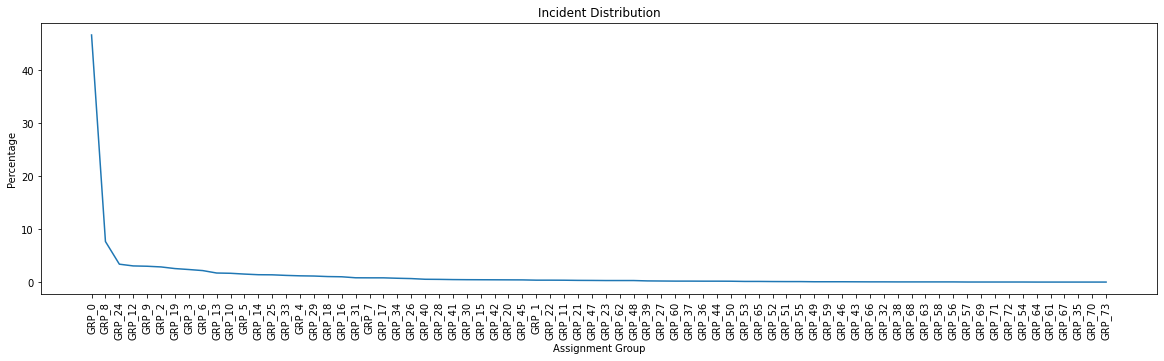

In [ ]:
plt.subplots(figsize = (20,5))
 
plt.plot(incidentnewset_groupby_Assignemntgrp["Assignment group"], incidentnewset_groupby_Assignemntgrp["count_perc"]) 
plt.xlabel('Assignment Group') 
plt.ylabel('Percentage') 
plt.xticks(rotation=90)
plt.title('Incident Distribution') 
  
 
plt.show()

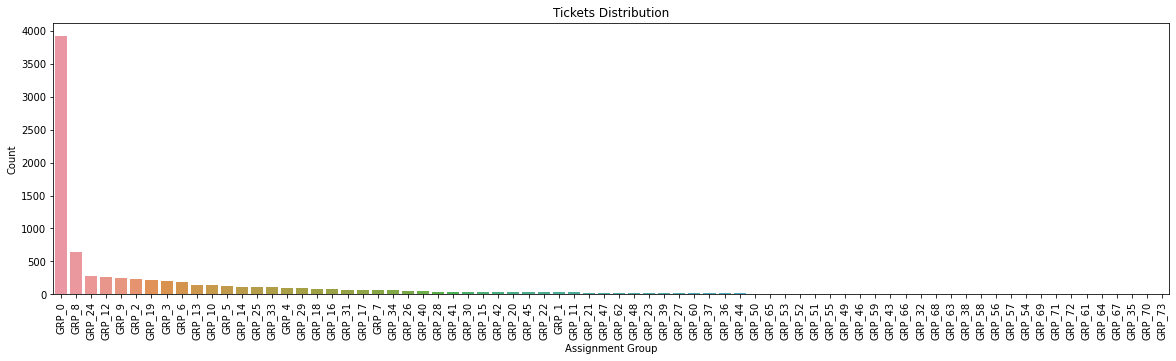

In [ ]:

plt.subplots(figsize = (20,5))

sns.countplot(x='Assignment group', data=incidents_newset,order = incidents_newset['Assignment group'].value_counts().index)
plt.xlabel('Assignment Group') 
plt.ylabel('Count') 
plt.xticks(rotation=90)
plt.title('Tickets Distribution')

plt.show()

In [ ]:
incidents_newset['Assignment group'].value_counts()

GRP_0     3926
GRP_8      645
GRP_24     285
GRP_12     257
GRP_9      252
          ... 
GRP_64       1
GRP_67       1
GRP_35       1
GRP_70       1
GRP_73       1
Name: Assignment group, Length: 74, dtype: int64

This is a long list of groups and the data is completely imbalanced

Trying to simplify the problem statement as there are a lot of groups with very less number of training data

In [ ]:
print('\nSum of counts between 0 and 50 : ',incidentnewset_groupby_Assignemntgrp[(incidentnewset_groupby_Assignemntgrp.counts<=50) & (incidentnewset_groupby_Assignemntgrp.counts>0)].sum())
print('\n\nSum of counts between 50 and 100 : ',incidentnewset_groupby_Assignemntgrp[(incidentnewset_groupby_Assignemntgrp.counts<=100) & (incidentnewset_groupby_Assignemntgrp.counts>50)].sum())
print('\n\nSum of counts between 100 and 150 : ',incidentnewset_groupby_Assignemntgrp[(incidentnewset_groupby_Assignemntgrp.counts<=150) & (incidentnewset_groupby_Assignemntgrp.counts>100)].sum())
print('\n\nSum of counts between 150 and 200 : ',incidentnewset_groupby_Assignemntgrp[(incidentnewset_groupby_Assignemntgrp.counts<=200) & (incidentnewset_groupby_Assignemntgrp.counts>150)].sum())


Sum of counts between 0 and 50 :  Assignment group    GRP_40GRP_28GRP_41GRP_30GRP_15GRP_42GRP_20GRP_...
counts                                                            758
count_perc                                                       9.04
dtype: object


Sum of counts between 50 and 100 :  Assignment group    GRP_4GRP_29GRP_18GRP_16GRP_31GRP_7GRP_17GRP_34...
counts                                                            692
count_perc                                                       8.24
dtype: object


Sum of counts between 100 and 150 :  Assignment group    GRP_13GRP_10GRP_5GRP_14GRP_25GRP_33
counts                                              754
count_perc                                         8.96
dtype: object


Sum of counts between 150 and 200 :  Assignment group    GRP_3GRP_6
counts                     383
count_perc                4.56
dtype: object


In [ ]:
Orig_countBYgrp = pd.DataFrame(incidents_newset['Assignment group'].value_counts())
Orig_countBYgrp = Orig_countBYgrp.T
Orig_countBYgrp

,GRP_0,GRP_8,GRP_24,GRP_12,GRP_9,GRP_2,GRP_19,GRP_3,GRP_6,GRP_13,...,GRP_54,GRP_69,GRP_71,GRP_72,GRP_61,GRP_64,GRP_67,GRP_35,GRP_70,GRP_73
Assignment group,3926,645,285,257,252,241,215,200,183,145,...,2,2,2,2,1,1,1,1,1,1


In [ ]:
incidents_newset['Count'] = incidents_newset.apply(lambda row: Orig_countBYgrp[row['Assignment group']] , axis=1)
incidents_newset['New Assignment group'] =incidents_newset['Assignment group'] 
incidents_newset.loc[(incidents_newset['Count'] <= 200) & (incidents_newset['Count'] > 150) , "New Assignment group"] = "GRP_CC"
incidents_newset.loc[(incidents_newset['Count'] <= 150) & (incidents_newset['Count'] > 100) , "New Assignment group"] = "GRP_CL"
incidents_newset.loc[(incidents_newset['Count'] <= 100) & (incidents_newset['Count'] > 50) , "New Assignment group"] = "GRP_C"
incidents_newset.loc[(incidents_newset['Count'] <= 50) & (incidents_newset['Count'] > 0) , "New Assignment group"] = "GRP_L"

In [ ]:
incidents_newset.drop(columns='Count',inplace=True)
incidents_newset.head()

,Short description,Description,Caller,Assignment group,Full Description,New Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,login issue -verified user details.(employee# ...,GRP_0
1,outlook,_x000D_\n_x000D_\nreceived from: hmjdrvpb.komu...,hmjdrvpb komuaywn,GRP_0,outlook _x000D_\n_x000D_\nreceived from: hmjdr...,GRP_0
2,cant log in to vpn,_x000D_\n_x000D_\nreceived from: eylqgodm.ybqk...,eylqgodm ybqkwiam,GRP_0,cant log in to vpn _x000D_\n_x000D_\nreceived ...,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,unable to access hr_tool page,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,skype error,GRP_0


In [ ]:
incidentnewset_groupby_NewAssignemntgrp = incidents_newset.groupby(['New Assignment group']).size().reset_index(name='new counts')
incidentnewset_groupby_NewAssignemntgrp

,New Assignment group,new counts
0,GRP_0,3926
1,GRP_12,257
2,GRP_19,215
3,GRP_2,241
4,GRP_24,285
5,GRP_8,645
6,GRP_9,252
7,GRP_C,692
8,GRP_CC,383
9,GRP_CL,754


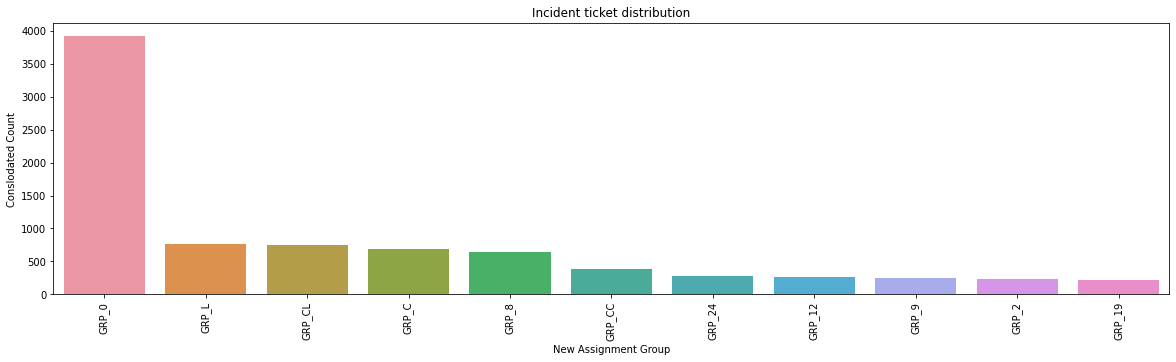

In [ ]:
plt.subplots(figsize = (20,5))

sns.countplot(x='New Assignment group', data=incidents_newset,order = incidents_newset['New Assignment group'].value_counts().index)
plt.xlabel('New Assignment Group') 
plt.ylabel('Conslodated Count') 
plt.xticks(rotation=90)
plt.title('Incident ticket distribution')

plt.show()

In [ ]:
# Lets ignore Group 0 for time being to understand the data spread which is 50% of the data
temp_data_without_grp0 = incidents_newset[incidents_newset["New Assignment group"] != 'GRP_0']
temp_data_without_grp0 

,Short description,Description,Caller,Assignment group,Full Description,New Assignment group
6,event: critical:HostName_221.company.com the v...,event: critical:HostName_221.company.com the v...,jyoqwxhz clhxsoqy,GRP_1,event: critical:HostName_221.company.com the v...,GRP_L
17,"when undocking pc , screen will not come back","when undocking pc , screen will not come back",sigfdwcj reofwzlm,GRP_3,"when undocking pc , screen will not come back",GRP_CC
32,duplication of network address.,\n\nreceived from: kxsceyzo.naokumlb@gmail.com...,kxsceyzo naokumlb,GRP_4,duplication of network address. \n\nreceived f...,GRP_C
43,please reroute jobs on printer01 to printer02 ...,\n\nreceived from: yisohglr.uvteflgb@gmail.com...,yisohglr uvteflgb,GRP_5,please reroute jobs on printer01 to printer02 ...,GRP_CL
47,job Job_1424 failed in job_scheduler at: 10/31...,received from: monitoring_tool@company.com_x00...,bpctwhsn kzqsbmtp,GRP_6,job Job_1424 failed in job_scheduler at: 10/31...,GRP_CC
...,...,...,...,...,...,...
8493,"erp fi - ob09, two accounts to be added","i am sorry, i have another two accounts that n...",ipwjorsc uboapexr,GRP_10,"erp fi - ob09, two accounts to be added i am ...",GRP_CL
8494,tablet needs reimaged due to multiple issues w...,tablet needs reimaged due to multiple issues w...,cpmaidhj elbaqmtp,GRP_3,tablet needs reimaged due to multiple issues w...,GRP_CC
8495,emails not coming in from zz mail,_x000D_\n_x000D_\nreceived from: avglmrts.vhqm...,avglmrts vhqmtiua,GRP_29,emails not coming in from zz mail _x000D_\n_x0...,GRP_C
8498,machine nÃ£o estÃ¡ funcionando,i am unable to access the machine utilities to...,ufawcgob aowhxjky,GRP_62,machine nÃ£o estÃ¡ funcionando i am unable to ...,GRP_L


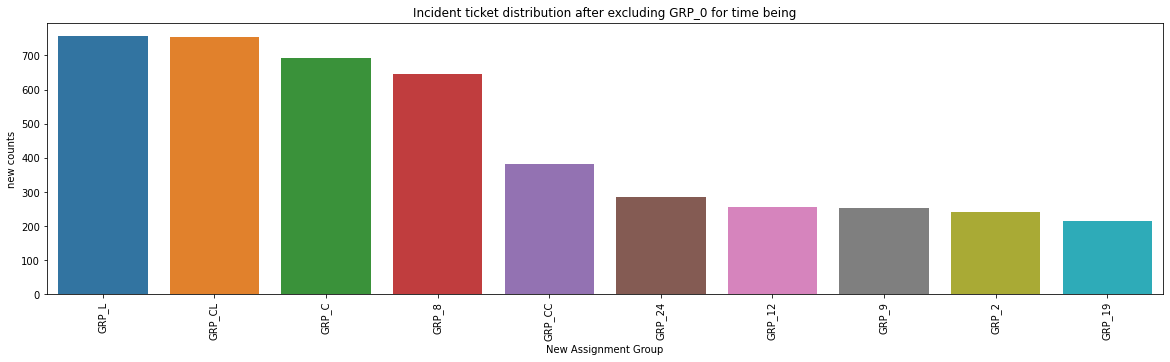

In [ ]:

plt.subplots(figsize = (20,5))

# plt.plot(temp_data_without_grp0["New Assignment group"], order = temp_data_without_grp0['New Assignment group'].value_counts().index) 
sns.countplot(x='New Assignment group', data=temp_data_without_grp0,order = temp_data_without_grp0['New Assignment group'].value_counts().index)
plt.xlabel('New Assignment Group') 
plt.ylabel('new counts') 
plt.xticks(rotation=90)

plt.title('Incident ticket distribution after excluding GRP_0 for time being') 
  

plt.show() 

Need to check with Mentor Arun whether this is accepted based on the Problem statement

We can find where the Description and short description are same - we can ignore this data appending and for others we can do the data append

Merging the short description and the Description columns to Full description column ensuring that the data is not repeated

In [ ]:
incidents_newset['Full Description'] = np.where(incidents_newset['Short description']==incidents_newset['Description'],incidents_newset['Description'], incidents_newset['Short description'] + ' '+ incidents_newset['Description'])

In [ ]:
incidents_newset.head(10)

,Short description,Description,Caller,Assignment group,Full Description,New Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,login issue -verified user details.(employee# ...,GRP_0
1,outlook,_x000D_\n_x000D_\nreceived from: hmjdrvpb.komu...,hmjdrvpb komuaywn,GRP_0,outlook _x000D_\n_x000D_\nreceived from: hmjdr...,GRP_0
2,cant log in to vpn,_x000D_\n_x000D_\nreceived from: eylqgodm.ybqk...,eylqgodm ybqkwiam,GRP_0,cant log in to vpn _x000D_\n_x000D_\nreceived ...,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,unable to access hr_tool page,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,skype error,GRP_0
5,unable to log in to engineering tool and skype,unable to log in to engineering tool and skype,eflahbxn ltdgrvkz,GRP_0,unable to log in to engineering tool and skype,GRP_0
6,event: critical:HostName_221.company.com the v...,event: critical:HostName_221.company.com the v...,jyoqwxhz clhxsoqy,GRP_1,event: critical:HostName_221.company.com the v...,GRP_L
7,ticket_no1550391- employment status - new non-...,ticket_no1550391- employment status - new non-...,eqzibjhw ymebpoih,GRP_0,ticket_no1550391- employment status - new non-...,GRP_0
8,unable to disable add ins on outlook,unable to disable add ins on outlook,mdbegvct dbvichlg,GRP_0,unable to disable add ins on outlook,GRP_0
9,ticket update on inplant_874773,ticket update on inplant_874773,fumkcsji sarmtlhy,GRP_0,ticket update on inplant_874773,GRP_0


In [ ]:
incident_df_final = incidents_newset.drop(columns=['Short description','Description','Caller','Assignment group'])
incident_df_final

,Full Description,New Assignment group
0,login issue -verified user details.(employee# ...,GRP_0
1,outlook _x000D_\n_x000D_\nreceived from: hmjdr...,GRP_0
2,cant log in to vpn _x000D_\n_x000D_\nreceived ...,GRP_0
3,unable to access hr_tool page,GRP_0
4,skype error,GRP_0
...,...,...
8495,emails not coming in from zz mail _x000D_\n_x0...,GRP_C
8496,telephony_software issue,GRP_0
8497,vip2: windows password reset for tifpdchb pedx...,GRP_0
8498,machine nÃ£o estÃ¡ funcionando i am unable to ...,GRP_L


Need to start work on Text processing / pre-processing